In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

### Load the data 

In [3]:
foods = pd.read_csv('../data/foodb_2017_06_29_csv/foods.csv',encoding='ANSI')
foods = foods.rename(columns={'name':'food_name','id':'food_id'})
# fix duplicate category
foods.food_group = foods.food_group.replace('Herbs and spices','Herbs and Spices')

In [1]:
contents_orig = pd.read_csv('../data/foodb_2017_06_29_csv/contents.csv',encoding='ANSI',error_bad_lines=False)
contents_keep_cols = ['orig_food_common_name','orig_food_id','orig_source_id','orig_source_name','source_type','standard_content']

In [11]:
compounds_orig = pd.read_csv('../data/foodb_2017_06_29_csv/compounds.csv',encoding='ANSI')
compounds_orig = compounds_orig.rename(columns={'name':'chem_name'})

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (13,14,17,45,50,51,54,55,62,63,64,65,66,67,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
nutrients_orig = pd.read_csv('../data/foodb_2017_06_29_csv/nutrients.csv')

### Sanity checks
Check to make sure that all food ids in contents are in foods table

In [13]:
sum(contents_orig.food_id.isin(foods.food_id))/len(contents_orig.food_id)

1.0

### Subset the contents table

Separate by source_type: nutrients vs compounds

In [14]:
contents_orig_nutrients = contents_orig[contents_orig['source_type']=='Nutrient']
contents_orig_compounds = contents_orig[contents_orig['source_type']=='Compound']

Add chemical hierarchy information to contents_orig_compounds

In [15]:
class_cols = ['superklass','klass','subklass']
compounds_class = compounds_orig[['chem_name','id']+class_cols]
compounds_class = compounds_class.rename(columns={'id':'source_id'})
contents_orig_compounds = contents_orig_compounds.merge(compounds_class,on='source_id',how='left')

### Construct crosstables for foods and nutrients

There are multiple entries for one pair of common name and source name, if a food has multiple parts (ie leaf, bulb, stem, etc.). For now just take the average

In [63]:
contents_nutrients_ct = pd.crosstab(index=contents_orig_nutrients['food_id'],columns=contents_orig_nutrients['orig_source_name'],values=contents_orig['standard_content'],aggfunc='mean')
contents_compounds_ct = pd.crosstab(index=contents_orig_compounds['food_id'],columns=contents_orig_compounds['subklass'],values=contents_orig['standard_content'],aggfunc='sum')

### Get the chemical class hierarchy

In [65]:
klassl2 = compounds_orig[['subklass','klass']].drop_duplicates().dropna(how='all').rename(columns={'subklass':'name','klass':'parent'})
klassl1 = compounds_orig[['klass','superklass']].drop_duplicates().dropna(how='all').rename(columns={'klass':'name','superklass':'parent'})
klassl0 = compounds_orig[['superklass']].drop_duplicates().dropna(how='all').rename(columns={'superklass':'name'})
klassl0['parent'] = 'Total Compounds'

In [66]:
objs = [klassl2,klassl1,klassl0]
klassinfo = pd.concat(objs,axis=0)
# klassinfo
klassinfo = klassinfo.append({'name':'Total Compounds','parent':''},ignore_index=True)

In [96]:
klassinfo.replace(np.nan,"Other").to_csv('../data/klassinfo.csv')

### Remove or aggregate duplicate columns

#### Nutrients

##### Fiber

In [68]:
fiber_cols = [col for col in contents_nutrients_ct.columns if 'Fiber' in col]

contents_nutrients_ct[fiber_cols].sample(10)

orig_source_name,"Fiber, dietary","Fiber, total dietary","Fiber, total dietary (AOAC)"
food_id,,,
489,NaN,7300.000000,NaN
156,1050.000000,4300.000000,0.0
610,666.666667,NaN,0.0
803,NaN,1900.000000,NaN
387,NaN,1300.000000,NaN
12,966.666667,807.692308,0.0
160,2428.571429,4428.571429,0.0
35,1200.000000,3100.000000,0.0
522,NaN,0.000000,NaN


`Fiber, total dietary (AOAC)` looks like mostly NaN's and zeros, so we can remove this

In [69]:
contents_nutrients_ct = contents_nutrients_ct.drop('Fiber, total dietary (AOAC)',axis=1)

The other two columns look like they agree in cases where they both contain data. If the columns both have data, we take the average, if only one has data we use this value, if neither column has data we leave the value as NaN

In [70]:
fiber_d = (~contents_nutrients_ct['Fiber, dietary'].isna())
fiber_td = (~contents_nutrients_ct['Fiber, total dietary'].isna())
both = fiber_d & fiber_td
contents_nutrients_ct.loc[both,'Fiber'] = contents_nutrients_ct.loc[both,['Fiber, dietary','Fiber, total dietary']].mean(axis=1)
contents_nutrients_ct.loc[fiber_d & ~both,'Fiber'] = contents_nutrients_ct.loc[fiber_d & ~both,'Fiber, dietary']
contents_nutrients_ct.loc[fiber_td & ~both,'Fiber'] = contents_nutrients_ct.loc[fiber_td & ~both,'Fiber, total dietary']

How complete is the final fiber column after this?

In [71]:
sum((~contents_nutrients_ct['Fiber'].isna()))/len(contents_nutrients_ct['Fiber'])

0.8946015424164524

Drop the old columns

In [72]:
contents_nutrients_ct = contents_nutrients_ct.drop(['Fiber, dietary','Fiber, total dietary'],axis=1)

##### Carbohydrates

In [73]:
carb_cols = [col for col in contents_nutrients_ct.columns if 'carb' in col or 'CARB' in col or 'Carb' in col]

contents_nutrients_ct[carb_cols].sample(10)

orig_source_name,CARBOHYDRATE,CARBOHYDRATES,CARBOHYDRATE|CARBOHYDRATES,"Carbohydrate, by difference","Carbohydrates, total","Carbohydrates, total available"
food_id,,,,,,
608,NaN,NaN,NaN,NaN,23000.0,17100.000000
275,NaN,NaN,NaN,64241.388889,65850.0,62433.333333
97,NaN,NaN,NaN,74970.000000,NaN,NaN
743,NaN,NaN,NaN,15115.000000,NaN,NaN
789,NaN,NaN,NaN,33146.000000,NaN,NaN
48,NaN,28647.60,NaN,3350.000000,3350.0,1350.000000
328,NaN,56203.75,NaN,38060.000000,38100.0,36300.000000
381,NaN,NaN,NaN,14856.000000,29300.0,21100.000000
475,NaN,NaN,NaN,1325.000000,NaN,NaN


Carb by difference seems like an outdated measurement technique [see here](https://www.encyclopedia.com/education/dictionaries-thesauruses-pictures-and-press-releases/carbohydrate-difference)

> Carbohydrate by difference: Historically it was difficult to determine the various carbohydrates present in foods, and an approximation was often made by subtracting the measured protein, fat, ash, and water from the total weight. Carbohydrate by difference is the sum of: nutritionally available carbohydrates (dextrins, starches, and sugars); nutritionally unavailable carbohydrate (pentosans, pectins, hemicelluloses, and cellulose) and non‐carbohydrates such as organic acids and lignins.

However, it looks like the most populated column. 

Total available describes only carbs that are metabolically available, so this is conceptually different from carbs in total. 

`CARBOHYDRATE`	`CARBOHYDRATES`	`CARBOHYDRATE|CARBOHYDRATES`	are all probably the same thing.


You would think that these would be mapped to different things in the `nutrients` file, but they're all just mapped to "Carbohydrate"

I'm just going to take the mean for now, ignoring NaN's and come back and do some more thoughtful cleaning if I have time

In [74]:
contents_nutrients_ct.loc[:,'Carbohydrates'] = contents_nutrients_ct.loc[:,carb_cols].mean(axis=1,skipna=True)
contents_nutrients_ct = contents_nutrients_ct.drop(carb_cols,axis=1)

Check completeness

In [75]:
sum((~contents_nutrients_ct['Carbohydrates'].isna()))/len(contents_nutrients_ct['Carbohydrates'])

0.993573264781491

##### Protein

In [76]:
prot_cols = [col for col in contents_nutrients_ct.columns if 'Protein' in col or 'PROTEIN' in col]

contents_nutrients_ct[prot_cols].sample(10)

orig_source_name,Adjusted Protein,PROTEIN,PROTEIN|PROTEINS,Protein,"Protein, total","Protein, total-N"
food_id,,,,,,
584,NaN,NaN,NaN,NaN,11000.000000,1800.000000
391,NaN,3150.0,NaN,720.000000,NaN,NaN
187,NaN,14800.0,NaN,12072.000000,NaN,NaN
753,NaN,NaN,NaN,7535.000000,NaN,NaN
61,NaN,13550.0,NaN,12143.333333,12133.333333,1933.333333
686,NaN,NaN,NaN,10808.571429,0.000000,0.000000
748,NaN,NaN,NaN,430.000000,NaN,NaN
590,NaN,NaN,NaN,NaN,17100.000000,2725.000000
410,NaN,2351.5,NaN,500.000000,NaN,NaN


In general, looks like 
- `PROTEIN` > `Protein` ~= `Protein, total` > `Protein, total-N`
- `Adjusted Protein` and `PROTEIN|PROTEINS` are mostly NaNs. 

`Protein` looks like the most complete column, it has a normal-sounding name, and the values look like they're in the middle, so this column seems trustworthy. We'll use this values if it exists, otherwise replace with the mean of the other columns. ¯\\_(ツ)_/¯

In [77]:
prot = ~contents_nutrients_ct['Protein'].isna()
other_prot_cols = ['PROTEIN','Protein, total','Protein, total-N']

In [78]:
contents_nutrients_ct.loc[~prot,'Protein'] = contents_nutrients_ct.loc[~prot,other_prot_cols].mean(axis=1,skipna=True)

In [79]:
contents_nutrients_ct = contents_nutrients_ct.drop([col for col in prot_cols if col != 'Protein'],axis=1)

Check for completeness

In [80]:
sum((~contents_nutrients_ct['Protein'].isna()))/len(contents_nutrients_ct['Protein'])

1.0

##### Fat

In [81]:
fat_cols = [col for col in contents_nutrients_ct.columns if 'fat' in col.lower()]

contents_nutrients_ct[fat_cols].sample(10)

orig_source_name,FAT,"Fat, total (Lipids)",Total lipid (fat)
food_id,,,
700,NaN,13800.000000,13810.000000
26,21825.0,NaN,773.333333
404,NaN,NaN,805.000000
524,NaN,600.000000,NaN
447,47500.0,NaN,41560.000000
375,NaN,15766.666667,15790.000000
402,NaN,200.000000,730.000000
621,NaN,4875.000000,5464.000000
646,NaN,0.000000,0.000000


I'm just going to take the mean

In [82]:
contents_nutrients_ct['Fat'] = contents_nutrients_ct[fat_cols].mean(axis=1,skipna=True)

In [83]:
contents_nutrients_ct =contents_nutrients_ct.drop(fat_cols,axis=1)

Check for completeness

In [84]:
sum((~contents_nutrients_ct['Fat'].isna()))/len(contents_nutrients_ct['Fat'])

1.0

### Merge the crosstables

In [85]:
results = contents_nutrients_ct.merge(contents_compounds_ct,how='left',on='food_id')

Drop rows without at least 10 nutrients

In [86]:
data = results.dropna(axis=0,thresh=10)

### Dimensionality reduction

PCA dimensionality reduction

In [87]:
# pca = PCA(n_components=2)
# pca_results = pd.DataFrame(pca.fit_transform(data.replace(np.nan,0)),columns=['PC1','PC2'],index=data.index)

# data = data.merge(pca_results,on='food_id')

t-SNE

In [88]:
tsne = TSNE(n_components=2)
tsne_results = pd.DataFrame(tsne.fit_transform(data.replace(np.nan,0)),columns=['ax1','ax2'],index=data.index)

data = data.merge(tsne_results,on='food_id')

In [89]:
foods_final = foods.rename(columns={'id':'food_id'}).merge(data,on='food_id',how='inner')
foods_final['food_group'] = pd.Categorical(foods_final['food_group'])
foods_final['food_group_cat']= foods_final.food_group.cat.codes

In [90]:
# foods_final = foods_final.loc[(foods_final['PC1'] < 0.5) & (abs(foods_final['PC2'])<1e6),:]

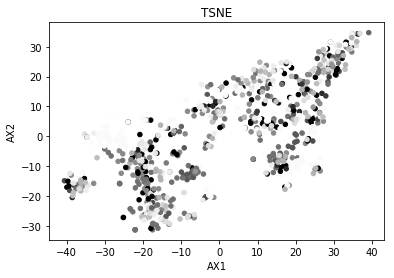

In [91]:
f, axes = plt.subplots(1, 1)
foods_final.plot.scatter('ax1','ax2',c=foods_final['food_group_cat'],ax=axes)
axes.set_xlabel('AX1')
axes.set_ylabel('AX2')
axes.set_title('TSNE')
plt.show()

### Export results to csv

In [92]:
foods_final.food_group = foods_final.food_group.replace('Herbs and spices','Herbs and Spices')

In [93]:
foods_final.to_csv('../data/foods_final.csv')